<a href="https://colab.research.google.com/github/jdasam/mas1004-2022/blob/main/notebooks/Data_AI_Week13_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Tutorial
### With Names from Different Countries

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt

import random
from tqdm.auto import tqdm

DEV= 'cuda'

## 0. Get Dataset

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2022-12-01 06:08:10--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.7, 13.249.85.10, 13.249.85.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2022-12-01 06:08:11 (38.2 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.

In [3]:
data_dir = Path('data/names')
txt_fns = data_dir.glob("*.txt")

names_in_dict = {}
for txt_fn in txt_fns:
  with open(txt_fn) as f:
    name_of_countries = f.readlines()
    print(f"Category: {txt_fn.stem}")
    names_in_dict[txt_fn.stem] = name_of_countries

Category: Spanish
Category: French
Category: English
Category: Dutch
Category: Scottish
Category: Czech
Category: Italian
Category: Arabic
Category: Irish
Category: Korean
Category: Japanese
Category: Vietnamese
Category: Greek
Category: Polish
Category: Chinese
Category: Portuguese
Category: German
Category: Russian


In [4]:
for key in names_in_dict:
  print(f"{key}: {names_in_dict[key][0][:-2]}, {len(names_in_dict[key])}")

Spanish: Aban, 298
French: Abe, 277
English: Abba, 3668
Dutch: Aalsbur, 297
Scottish: Smit, 100
Czech: Ab, 519
Italian: Abandonat, 709
Arabic: Khour, 2000
Irish: Ada, 232
Korean: Ah, 94
Japanese: Ab, 991
Vietnamese: Nguye, 73
Greek: Adamidi, 203
Polish: Adamcza, 139
Chinese: An, 268
Portuguese: Abre, 74
German: Abbin, 724
Russian: Ababk, 9408


## 1. Define Dataset

In [5]:
def normalize_name(name):
  return name.replace('\n', '').replace(u'\xa0', u' ').lower()


In [57]:
class NameSet:
  def __init__(self, data_dir='data/names'):
    self.dir = Path(data_dir)
    txt_fns = list(self.dir.glob('*.txt'))

    total_names = [] 
    for txt_fn in txt_fns:
      with open(txt_fn, 'r') as f:
        names = f.readlines()
      origin = txt_fn.stem.lower()
      names = [(normalize_name(name), origin) for name in names]
      # print(names)
      total_names += names
    # print(total_names)
    self.data = total_names
    self.unique_characters = ['<pad>'] + self.get_unique_characters_of_dataset()
    self.char2idx = {character: idx for idx, character in enumerate(self.unique_characters)}
    self.origin_vocab = self.get_unique_origin_of_dataset()
    self.origin2idx = {origin:idx for idx, origin in enumerate(self.origin_vocab)}

  def get_unique_characters_of_dataset(self):
    # first, get name of every datasample
    names = [name_origin[0] for name_origin in self.data]
    characters = [character for name in names for character in name]
    return sorted(list(set(characters)))
    # characters = []
    # for name in names:
    #   # name: "kim"
    #   for character in name:
    #     # character: "k", "i", "m"
    #     characters.append(character)

  def get_unique_origin_of_dataset(self):
    origins = [name_origin[1] for name_origin in self.data]
    return sorted(list(set(origins)))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    name, origin = self.data[idx]
    name_in_indices = [self.char2idx[char]  for char in name]
    origin_in_indices = self.origin2idx[origin]
    return torch.tensor(name_in_indices), origin_in_indices

dataset = NameSet()
print(dataset.unique_characters)
print(len(dataset.unique_characters))

dataset[0]
# for idx, char in enumerate(dataset.unique_characters):
#   print(idx, char)

['<pad>', ' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'õ', 'ö', 'ù', 'ú', 'ü', 'ą', 'ł', 'ń', 'ś', 'ż']
58


(tensor([ 8,  9,  8, 21,  8]), 16)

In [7]:
dataset.origin2idx['korean']

11

In [8]:
[dataset.unique_characters[char]  for char in [7, 8, 7, 20, 7]] 

['a', 'b', 'a', 'n', 'a']

### 1-1 Add zero-padding 
- Each name in the dataset has a different length
- Therefore, you have to add zero padding so that each data sample in a batch has same length
  - If you use zero-padding, it is better to not use index 0 for input category
  - For example, if you represent `"a"` as a categorical index 0 and then use zero padding, you cannot figure out whether `[0, 0, 0, 0]` is just padded zeros or `[a, a, a, a]`

In [58]:
def pad_collate(raw_batch):
  print(raw_batch)
  # get maximum length of sequence in the batch
  names = [x[0] for x in raw_batch]
  origins = [x[1] for x in raw_batch]

  len_of_names = [len(name) for name in names]
  max_len = max(len_of_names)

  padded_name = torch.zeros(len(names), max_len, dtype=torch.long)
  # print(names)
  # print(len_of_names)
  # print(padded_name)
  for i, name in enumerate(names):
    padded_name[i, 0:len(name)] = name
  # print(padded_name)

  return padded_name, torch.tensor(origins, dtype=torch.long) 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_collate)

batch = next(iter(dataloader))
batch

[(tensor([26,  8, 25, 11, 12, 19, 16, 26]), 7), (tensor([17,  8, 29, 22, 25, 22, 21, 18, 22, 29]), 14), (tensor([14, 15,  8, 21, 12, 20]), 0), (tensor([10, 15, 28, 29,  8, 26, 15, 22, 29]), 14)]


(tensor([[26,  8, 25, 11, 12, 19, 16, 26,  0,  0],
         [17,  8, 29, 22, 25, 22, 21, 18, 22, 29],
         [14, 15,  8, 21, 12, 20,  0,  0,  0,  0],
         [10, 15, 28, 29,  8, 26, 15, 22, 29,  0]]), tensor([ 7, 14,  0, 14]))

In [48]:
# example of raw_batch
[dataset[0], dataset[1]]

[(tensor([ 7,  8,  7, 20,  7]), 16), (tensor([ 7,  8,  7, 20, 21]), 16)]

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

batch = next(iter(dataloader))
name, origin = batch

In [14]:
emb_dim = 9
char_emb = nn.Embedding(len(dataset.unique_characters), emb_dim)

print(name)
embedding_output = char_emb(name)
print(embedding_output.shape)
print(embedding_output)

tensor([[11, 24, 20, 11, 25, 26]])
torch.Size([1, 6, 9])
tensor([[[ 1.1540,  1.0368,  2.2881, -0.4761, -0.2839, -1.0220, -0.9013,
          -1.2717, -1.9320],
         [ 1.2905,  0.5848, -1.0608,  1.0251,  0.3588, -1.0298,  0.1126,
          -0.9964,  0.7366],
         [ 1.4476, -0.1589, -0.0471,  0.4494,  1.4020, -0.4257, -1.4666,
           0.0299,  1.1522],
         [ 1.1540,  1.0368,  2.2881, -0.4761, -0.2839, -1.0220, -0.9013,
          -1.2717, -1.9320],
         [-1.8705, -0.4139,  0.9510, -1.2738,  0.2722,  0.0699,  1.5257,
          -0.9634, -0.8841],
         [-1.0268, -1.9292,  0.2116, -1.3874, -0.7819, -1.3972, -1.9147,
          -1.9806,  0.4860]]], grad_fn=<EmbeddingBackward0>)


In [20]:
rnn_layer = nn.RNN(input_size=emb_dim, hidden_size=17, batch_first=True)
# batch_first True means that the layer will handle the input 
# as Batch x Time x Hidden
# if batch_first is False, the laywer will handle the input as
# Time x Batch x Hidden 
print(embedding_output.shape)
rnn_output, rnn_final_hidden = rnn_layer(embedding_output)
print(rnn_output)
print(rnn_final_hidden)
print(rnn_output.shape, rnn_final_hidden.shape)

torch.Size([1, 6, 9])
tensor([[[ 0.5732,  0.5040, -0.4716,  0.3047,  0.8236,  0.4933,  0.0151,
          -0.1172, -0.0868,  0.5150, -0.8261,  0.5427, -0.6894,  0.5543,
           0.5910, -0.5796, -0.1716],
         [-0.0103, -0.1954,  0.3754,  0.1054,  0.1507,  0.0994, -0.4464,
           0.0714, -0.5411,  0.1264,  0.6758,  0.1798, -0.7359,  0.0593,
          -0.5565, -0.2707,  0.1376],
         [-0.2830, -0.3521,  0.1986, -0.1865,  0.5912, -0.2174, -0.2612,
          -0.2752, -0.0190,  0.2996,  0.5237,  0.4835, -0.0698, -0.4818,
          -0.4917, -0.2126,  0.5026],
         [ 0.5708,  0.4756, -0.6242,  0.0846,  0.8551,  0.4885, -0.0071,
          -0.2137, -0.2512,  0.4301, -0.7565,  0.3872, -0.6542,  0.6941,
           0.7734, -0.7493, -0.2683],
         [ 0.7715,  0.6399,  0.2627,  0.0443,  0.2192,  0.3618,  0.0891,
          -0.8545, -0.3568, -0.0761, -0.5859,  0.0714,  0.0108, -0.0753,
           0.0702,  0.4608, -0.0946],
         [ 0.6353,  0.7664,  0.8629, -0.4369,  0.7028, -0.

## 2. Make RNN Model
### 2-1. See how RNN works
- Since our input is a categorical index, we will use nn.Embedding
- ![Diagram](https://datascience-enthusiast.com/figures/rnn_step_forward.png)

In [22]:
torch.manual_seed(0)
test_input = torch.randn([11, 4])
test_input[7] = torch.zeros(4) # let's just change the 7th input

input_to_hidden_layer = nn.Linear(4, out_features=5)
hidden_to_hidden_layer = nn.Linear(5, 5)

initial_hidden_state = torch.zeros(5)
initial_hidden_state
prev_hidden_state = initial_hidden_state

time_step = 0

hidden_outputs = []

for time_step in range(len(test_input)):
  current_input = test_input[time_step]
  current_input_to_hidden = input_to_hidden_layer(current_input)
  print(current_input_to_hidden)
  current_hidden_to_hidden = hidden_to_hidden_layer(prev_hidden_state)
  print(current_hidden_to_hidden)
  current_hidden_state = current_input_to_hidden + current_hidden_to_hidden
  current_hidden_state = torch.tanh(current_hidden_state)
  print(current_hidden_state)
  prev_hidden_state = current_hidden_state
  hidden_outputs.append(current_hidden_state)
hidden_outputs = torch.stack(hidden_outputs, dim=0)

tensor([-0.9437,  0.1529, -0.3462, -1.4978,  0.6068], grad_fn=<AddBackward0>)
tensor([-0.1831,  0.2654, -0.2721,  0.4058,  0.3065], grad_fn=<AddBackward0>)
tensor([-1.1269,  0.4183, -0.6184, -1.0920,  0.9133], grad_fn=<AddBackward0>)
tensor([-0.3607,  0.3824,  1.4850, -1.1160,  0.5243], grad_fn=<AddBackward0>)
tensor([-0.4322, -0.6096,  0.2361, -0.0878,  0.4762], grad_fn=<AddBackward0>)
tensor([-0.7929, -0.2272,  1.7211, -1.2038,  1.0005], grad_fn=<AddBackward0>)
tensor([-0.7042,  0.6548, -0.3177, -0.6706,  0.5947], grad_fn=<AddBackward0>)
tensor([-0.9311, -0.0091,  0.2306, -0.6226, -0.1075], grad_fn=<AddBackward0>)
tensor([-1.6353,  0.6457, -0.0871, -1.2932,  0.4871], grad_fn=<AddBackward0>)
tensor([-0.5581,  0.3917,  0.6266,  0.4143, -0.3039], grad_fn=<AddBackward0>)
tensor([-0.4411, -0.3164,  0.6640, -0.1326,  0.1968], grad_fn=<AddBackward0>)
tensor([-0.9992,  0.0753,  1.2905,  0.2817, -0.1071], grad_fn=<AddBackward0>)
tensor([-1.1610,  0.2827, -1.2173, -0.8705,  0.4742], grad_fn=<A

In [21]:
# hidden_outputs = torch.stack(hidden_outputs, dim=0)
print(hidden_outputs.shape)
print(hidden_outputs)

torch.Size([11, 5])
tensor([[-1.1269,  0.4183, -0.6184, -1.0920,  0.9133],
        [-0.7929, -0.2272,  1.7211, -1.2038,  1.0005],
        [-1.6353,  0.6457, -0.0871, -1.2932,  0.4871],
        [-0.9992,  0.0753,  1.2905,  0.2817, -0.1071],
        [-1.4618,  0.9090, -1.1327, -1.1002,  0.3041],
        [-0.4400,  0.4650,  0.1657, -0.0765,  0.6844],
        [-0.7475,  0.7408,  0.1903, -0.5428,  0.5015],
        [-1.2924,  0.5724, -0.2626, -0.0653,  0.3060],
        [-0.8949,  0.1977,  0.3012,  0.2309, -0.1231],
        [-0.0384,  0.8418,  0.3796, -0.6060, -0.3019],
        [-0.6968,  1.3023, -0.3603,  2.6543, -1.3842]],
       grad_fn=<StackBackward0>)


In [23]:
print(hidden_outputs.shape)
print(hidden_outputs)

torch.Size([11, 5])
tensor([[-1.1269,  0.4183, -0.6184, -1.0920,  0.9133],
        [-0.7929, -0.2272,  1.7211, -1.2038,  1.0005],
        [-1.6353,  0.6457, -0.0871, -1.2932,  0.4871],
        [-0.9992,  0.0753,  1.2905,  0.2817, -0.1071],
        [-1.4618,  0.9090, -1.1327, -1.1002,  0.3041],
        [-0.4400,  0.4650,  0.1657, -0.0765,  0.6844],
        [-0.7475,  0.7408,  0.1903, -0.5428,  0.5015],
        [-0.9125,  0.5028,  0.5683, -0.3739,  0.1380],
        [-1.0971,  0.5330,  0.4041,  0.3141, -0.3931],
        [ 0.0169,  1.0509,  0.5633, -0.5044, -0.4689],
        [-0.6922,  1.5083, -0.3049,  2.7645, -1.5321]],
       grad_fn=<StackBackward0>)


## 2.2 Make Name Classification Model
- Input: Sequence of characters, in categorical indices
  - Length of the input sequence is arbitrary 
- Output: Probability of the corresponding nationality for a given name in a sequence of characters
  - Regardless of input length, the output is a single vector
  - Softmax output of each class

In [38]:
class NameClassifier(nn.Module):
  def __init__(self, hidden_size, num_vocab, num_outputs):
    super().__init__()
    self.embedding = nn.Embedding(num_vocab, hidden_size)
    self.rnn = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
    self.projection_layer = nn.Linear(hidden_size, num_outputs)
  
  def forward(self, x):
    emb = self.embedding(x)
    rnn_output, rnn_final_hidden = self.rnn(emb)
    rnn_final_hidden_flatten = rnn_final_hidden.permute(1,0,2).reshape(x.shape[0], -1)
    logit = self.projection_layer(rnn_final_hidden_flatten)

    return logit

hidden_size = 32
num_vocab = len(dataset.unique_characters)
num_outputs = len(dataset.origin_vocab)
model = NameClassifier(hidden_size, num_vocab, num_outputs)

model

NameClassifier(
  (embedding): Embedding(57, 32)
  (rnn): RNN(32, 32, batch_first=True)
  (projection_layer): Linear(in_features=32, out_features=18, bias=True)
)

In [28]:
num_outputs

18

In [40]:
batch = next(iter(dataloader))
name, origin = batch

model(name).softmax(dim=-1)

tensor([[0.0661, 0.0339, 0.0343, 0.0458, 0.0438, 0.0584, 0.0613, 0.0469, 0.0746,
         0.0430, 0.0519, 0.0729, 0.0427, 0.0797, 0.0413, 0.0749, 0.0804, 0.0481]],
       grad_fn=<SoftmaxBackward0>)

## 2.3 Complete Trainer

In [42]:
class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='resnet'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)
    self.criterion = nn.NLLLoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self.model(images)
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)

        loss = self.criterion(log_probs, labels)
        predicted_classes = torch.argmax(outputs, dim=-1)
        num_acc_pred = (predicted_classes == labels.to(self.device)).sum()
        #num_acc_pred is on self.device
        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(labels)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(images) # this is logits
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)
        # print(f"Debug log probs: {log_probs.shape} / {labels.shape}")
        loss = self.criterion(log_probs, labels) # you have to feed log_probs

        acc = (torch.argmax(outputs, dim=-1) == labels.to(self.device)).sum() / len(labels)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best? 
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")


num_train = int(len(dataset)*0.7)
num_valid = int(len(dataset)*0.15)
num_test = len(dataset) - num_train - num_valid
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, 
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

trainer = Trainer(model, train_loader, valid_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14051 [00:00<?, ?it/s]

Saving best model at epoch 0, acc: 0.7143806044503487


  0%|          | 0/14051 [00:00<?, ?it/s]

Saving best model at epoch 1, acc: 0.7455994686150781


  0%|          | 0/14051 [00:00<?, ?it/s]

Saving best model at epoch 2, acc: 0.7482563932248423


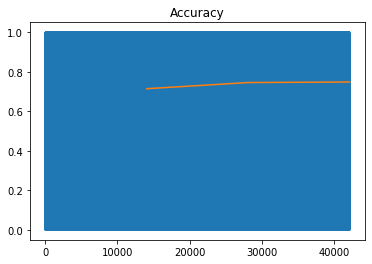

In [43]:
trainer.train_by_number_of_epochs(3)

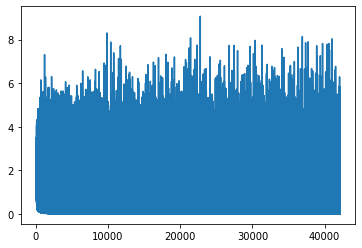

In [44]:
plt.plot(trainer.train_losses)